## Computation of confidence intervals using a grid search
Computing confidence intervals using a grid search is a method particularly useful when analytic solutions are unavailable. By evaluating the parameter space, calculating posterior probabilities for every point, and deriving credible intervals we get a confidence interval given the data and prior knowledge such that P[Θ ∈ I | X] = 1−α where alpha is our confidence level. In this manner  it is an analogue to a frequentist confidence interval.

By first creating a fine grid of plausible values for our parameters and defining a posterior, following bayesian inference, we can compute the value of the posterior in each point. Meaning that every combination of n parameters is used to calculate the posterior giving a hypercube filled with **m_1 \cdot m_2 \cdot ... \cdot m_n** points. (for ** m_i** the total number of chosen grid values).
 

To identify the confidence interval we have two main methods. For symmetric distributions we look at an equal tail approximation. The interval [θ(α/2),θ(1−α/2)] determines the region where all points lay such the probability for a point to lay in this interval is 1- alpha. This reflects the true probability the value of our parameter lies in that interval. However this brings some ambiguity into play. Imagine a simple gaussian distribution. we can construct a alpa =0.5 interval on the left side going from -inf to the mean or an interval on the right side. we can also have the mean in the middle of the interval and symmetrically go to both side. To solve this ambivalence we try to minimize the length of the interval. Or let the interval be determined by equalling the excluded area on both tail-ends.



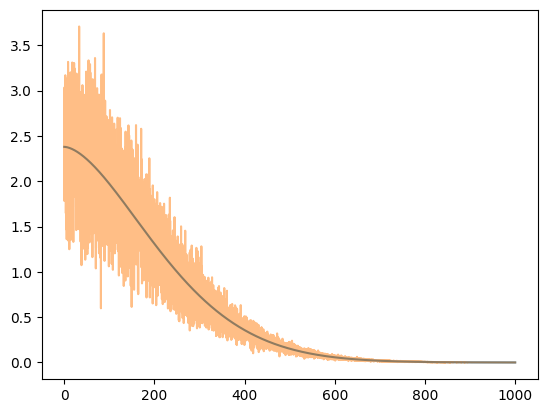

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
import numpy as np
import scipy.optimize as opt
import scipy.special as sp

import matplotlib.pyplot as plt

# -------------------- Step 1: Simulate Gravitational Wave Data --------------------
np.random.seed(12390847)

# True source location in RA and Dec
true_n = 0.6
true_r_e = 250
R_max  = 1e3 


def sersic_profile(r, r_e, n):
    """Compute the Sérsic profile"""
    b_n = 2 * n - 1/3  # Approximation for b_n for n > 0.5
    return np.exp(-b_n * ((r / r_e)**(1/n) - 1))
   
def sim_data(r,r_e,n, fractional_uncertainty):
	y_true = sersic_profile(r,r_e,n)
	y_unc_true = np.abs(y_true)*fractional_uncertainty
	y_sample = np.random.normal(y_true, y_unc_true, size=len(r))
	return y_sample, y_unc_true


#simulating data
fractional_uncertainty = 0.2
r_range = np.linspace(0,R_max,10000)

sim_r, sim_r_uncertainty = sim_data(r_range, true_r_e, true_n, fractional_uncertainty)


plt.figure()
plt.plot(r_range, sersic_profile(r_range, true_r_e, true_n))
plt.plot(r_range, sim_r, alpha=0.5)
plt.show()

# -------------------- Step 2: Define Prior and Likelihood --------------------

def flat_prior(r_e,n ):
    """
    Flat prior: Assuming parameters are bounded in some range [min, max].
    """
    if 0 <= n <= 10 and 0 <= r_e <= R_max:  # Example bounds
        return 1
    return 0

def log_likelihood(simulated, model_param, sigma):
    """Log-likelihood for the observed 2D data at each grid point."""
    r, r_e, n = model_param
    model = sersic_profile(r, r_e, n)
    return -0.5 * np.sum((simulated - model) ** 2 / (sigma ** 2))


def log_likelihood(r, observed_intensity, sigma, r_e, n,):

    model_density = sersic_profile(r, r_e, n)
    
    # Compute log-likelihood assuming Gaussian errors
    log_likelihood_value = -np.sum(0.5 * ((observed_intensity - model_density) / sigma) ** 2 + np.log(sigma * np.sqrt(2 * np.pi)))
    return  log_likelihood_value



In [136]:
# Create a 2D grid of RA and Dec

r_e_space = np.linspace(1, R_max, 200)
n_space = np.linspace(0.5, 1, 200)


posterior_grid = np.zeros((len(r_e_space),len(n_space)))

# Loop over all combinations of n and r_e
for i in tqdm(range(len(n_space))):
    for j in range(len(r_e_space)):
        prior = flat_prior(r_e_space[j], n_space[i] )
        # Compute likelihood for this position (using the simulated data)
        model_param = r_range, n_space[i], r_e_space[j]
        likelihood_value = log_likelihood(r_range, sim_r, sim_r_uncertainty,r_e_space[j], n_space[i] )
        # Compute the posterior for this position (product of likelihood and prior)
        posterior_grid[i, j] = likelihood_value * prior


posterior_grid = np.exp(posterior_grid - np.max(posterior_grid))  # Prevent overflow
posterior_grid /= np.sum(posterior_grid)  # Normalize


max_idx = np.unravel_index(np.argmax(posterior_grid), posterior_grid.shape)

#  best-fit parameters
best_fit_n = n_space[max_idx[0]]
best_fit_r_e = r_e_space[max_idx[1]]

print(f"Best-fit n: {best_fit_n}")
print(f"Best-fit r_e: {best_fit_r_e}")

        

100%|██████████| 200/200 [00:11<00:00, 17.10it/s]

Best-fit n: 0.5904522613065326
Best-fit r_e: 252.00502512562812


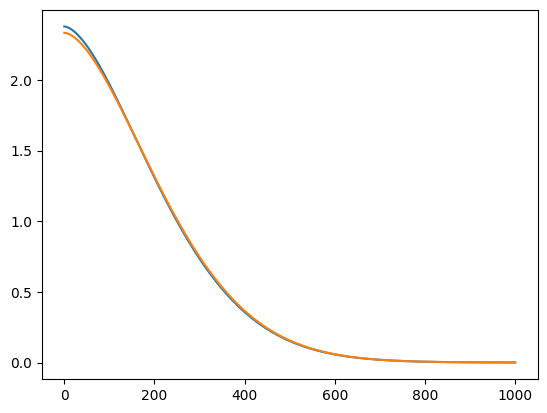

In [137]:
plt.figure()
plt.plot(r_range, sersic_profile(r_range, true_r_e,true_n))
plt.plot(r_range, sersic_profile(r_range, best_fit_r_e,best_fit_n))
plt.show()


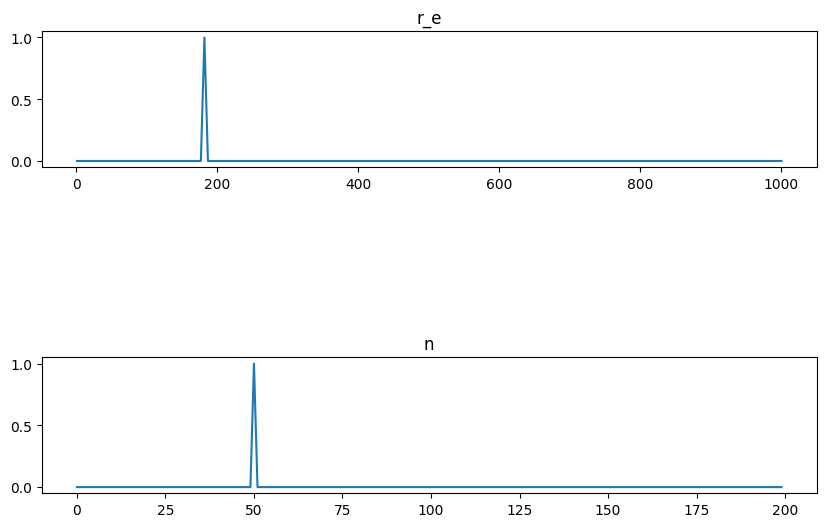

In [139]:
r_e_mag = np.sum(posterior_grid, axis= 1)
n_mag = np.sum(posterior_grid, axis= 0)


plt.figure(figsize=(10,6))
plt.subplot(3,1, 1)
plt.title("r_e")
plt.plot(r_e_space, r_e_mag)


plt.subplot(3,1, 3)
plt.title("n")
plt.plot(n_mag)

plt.show()
